In [34]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Define a new bijector: Cubic

class Cubic(tfb.Bijector):
    
    def __init__(self, a, b, validate_args=False, name='Cubic'):
        self.a = tf.cast(a, tf.float32)
        self.b = tf.cast(b, tf.float32)
        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-5), tf.float32)) == 1.0
        super(Cubic, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=0, name=name)
        
    def _forward(self, x):
        x = tf.cast(x, tf.float32)
        return tf.squeeze(tf.pow(self.a * x + self.b, 3))
    
    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        return (tf.math.sign(y) * tf.pow(tf.abs(y), 1/3) - self.b) / self.a
    
    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x, tf.float32)
        return tf.math.log(3. * tf.abs(self.a)) + 2. * tf.math.log(tf.abs(self.a * x + self.b))

In [8]:
# Cubic bijector

cubic = Cubic([1.0, -2.0], [-1.0, 0.4], validate_args=True)

In [10]:
# Apply forward transformation

x = tf.constant([[1,2], [3, 4]])
y = cubic.forward(x)
print(y)

tf.Tensor(
[[   0.        -46.655994]
 [   8.       -438.97598 ]], shape=(2, 2), dtype=float32)


In [17]:
cubic.inverse(y)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [3, 4]], dtype=int32)>

In [14]:
# Check inverse

np.linalg.norm(x - cubic.inverse(y))

0.0

In [15]:
x - cubic.inverse(y)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 0],
       [0, 0]], dtype=int32)>

#### Function plots

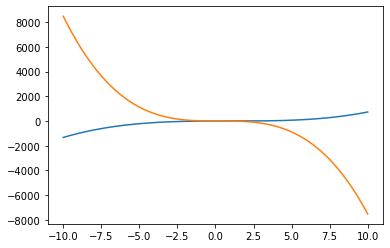

In [21]:
# Plot the forward transformation

x = np.linspace(-10, 10, 500).reshape(-1, 1)
plt.plot(x, cubic.forward(x));

These two curves represent the two different values that we have set for a and b.

In [22]:
# Display shape

print(cubic.forward(x).shape)

(500, 2)


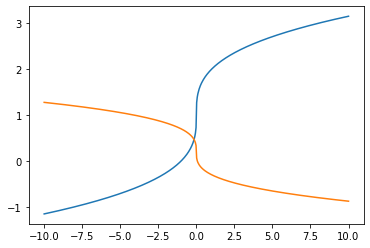

In [25]:
x = np.linspace(-10, 10, 500).reshape(-1, 1)
plt.plot(x, cubic.inverse(x));

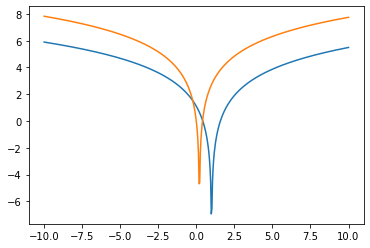

In [27]:
# Plot the forward log Jacobian determinant

plt.plot(x, cubic.forward_log_det_jacobian(x, event_ndims=0));

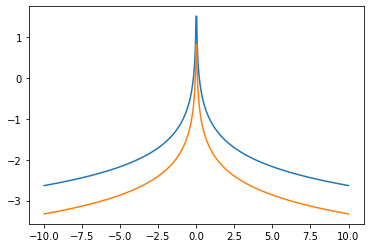

In [30]:
# Plot the inverse log Jacobian determinant

plt.plot(x, cubic.inverse_log_det_jacobian(x, event_ndims=0));

### Transformed distribution

In [52]:
# Create a transformed distribution with Cubic

normal = tfd.Normal(loc=0., scale=[1,1])
normal = tfd.Independent(normal, reinterpreted_batch_ndims=1)

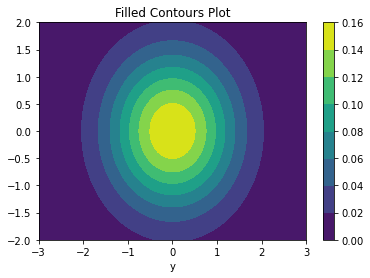

In [79]:
# Make contour plot BEFORE transformation

xx = np.linspace(-3, 3, 100)
yy = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(xx, yy)

fig, ax = plt.subplots(1,1)
Z = normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_xlabel('y')
plt.show()

In [62]:
# Sample normal

n = 1000
g = normal.sample(n)
g.shape

TensorShape([1000, 2])

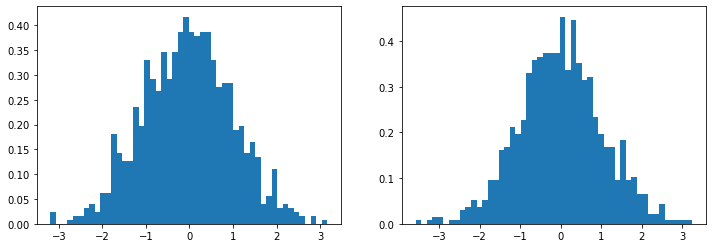

In [63]:
# Plot histograms BEFORE transformation

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(g[..., 0].numpy(), bins=50, density=True)
plt.subplot(1,2,2)
plt.hist(g[...,1].numpy(), bins=50, density=True)
plt.show()

In [53]:
cubed_normal = tfd.TransformedDistribution(normal, cubic)
cubed_normal

<tfp.distributions.TransformedDistribution 'CubicIndependentNormal' batch_shape=[] event_shape=[2] dtype=float32>

In [64]:
# Sample cubed_normal

n = 1000
g = cubed_normal.sample(n)
g.shape

TensorShape([1000, 2])

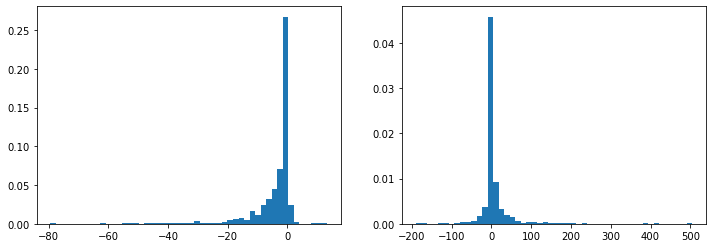

In [65]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(g[..., 0].numpy(), bins=50, density=True)
plt.subplot(1,2,2)
plt.hist(g[...,1].numpy(), bins=50, density=True)
plt.show()

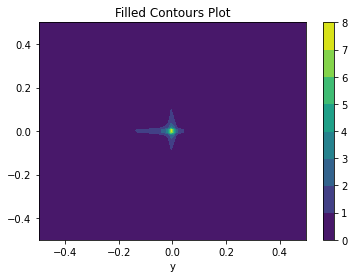

In [66]:
# Make contour plot after transformation

xx = np.linspace(-0.5, 0.5, 100)
yy = np.linspace(-0.5, 0.5, 100)
X, Y = np.meshgrid(xx, yy)

fig, ax = plt.subplots(1,1)
Z = cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_xlabel('y')
plt.show()

In [81]:
# Create a transformed distribution with the inverse of Cube

inverse_cubic = tfb.Invert(cubic)
inv_cubed_normal = inverse_cubic(normal)

In [82]:
# Sample from the inverse cubic normal

n = 1000
g = inv_cubed_normal.sample(n)
g.shape

TensorShape([1000, 2])

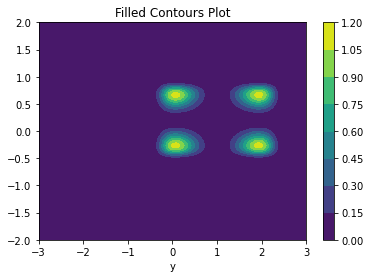

In [83]:
# Make contour plot inverse transformation

xx = np.linspace(-3, 3, 100)
yy = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(xx, yy)

fig, ax = plt.subplots(1,1)
Z = inv_cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_xlabel('y')
plt.show()

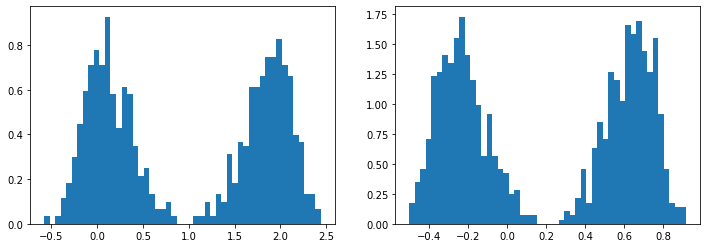

In [84]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(g[..., 0].numpy(), bins=50, density=True)
plt.subplot(1,2,2)
plt.hist(g[...,1].numpy(), bins=50, density=True)
plt.show()

### Training the bijector

In [98]:
# Create a mixture of four Gaussians

probs = [0.45, 0.55]
mix_gauss = tfd.Mixture(
                    cat=tfd.Categorical(probs=probs),
                    components=[
                        tfd.Normal(loc=2.3, scale=0.4),
                        tfd.Normal(loc=-0.8, scale=0.4)
                    ])

In [87]:
# Create the dataset

x_train = mix_gauss.sample(10000)
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(128)

x_valid = mix_gauss.sample(1000)
x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
x_valid = x_valid.batch(128)

print(x_train.element_spec)
print(x_valid.element_spec)

TensorSpec(shape=(None,), dtype=tf.float32, name=None)
TensorSpec(shape=(None,), dtype=tf.float32, name=None)


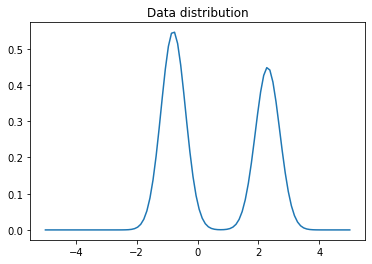

In [89]:
# Plot the data distribution

x = np.linspace(-5, 5, 100)
plt.plot(x, mix_gauss.prob(x))
plt.title('Data distribution');

In [116]:
# Make a trainable bijector

trainable_inv_cubic = tfb.Invert(Cubic(tf.Variable(0.25), tf.Variable(-0.1)))
trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.25>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.1>)

In [117]:
normal = tfd.Normal(loc=0., scale=1)
normal

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [118]:
# Make a trainable transformed distribution

trainable_dist = tfd.TransformedDistribution(normal, trainable_inv_cubic)

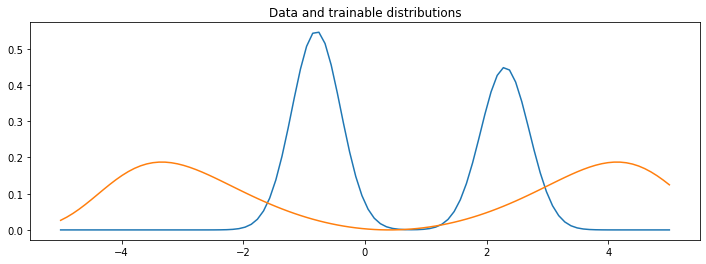

In [119]:
# Plot the data and learned distributions

x = np.linspace(-5.0, 5, 100)

plt.figure(figsize=(12, 4))
plt.plot(x, mix_gauss.prob(x), label='data')
plt.plot(x, trainable_dist.prob(x), label='trainable')
plt.title('Data and trainable distributions')
plt.show()

In [120]:
# Train the bijector

num_epochs = 20
opt = tf.keras.optimizers.Adam()
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print('Epoch {}...'.format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    
    for train_batch in x_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_inv_cubic.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_inv_cubic.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_inv_cubic.trainable_variables))
    train_losses.append(train_loss.result().numpy())
    
    # validation
    for valid_batch in x_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...
Epoch 10...
Epoch 11...
Epoch 12...
Epoch 13...
Epoch 14...
Epoch 15...
Epoch 16...
Epoch 17...
Epoch 18...
Epoch 19...


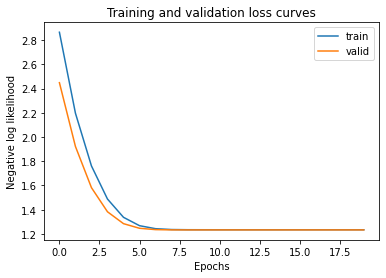

In [121]:
# Plot the learning curves

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title('Training and validation loss curves')
plt.show()

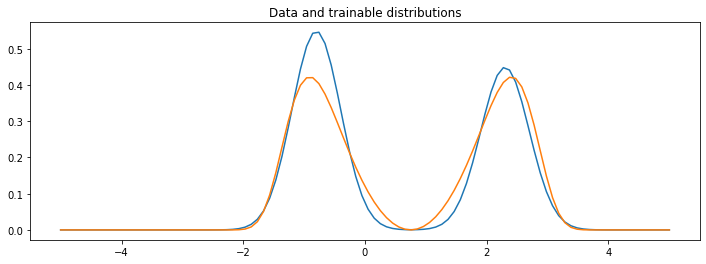

In [122]:
# Plot the data and learned distribution

x = np.linspace(-5.0, 5, 100)

plt.figure(figsize=(12, 4))
plt.plot(x, mix_gauss.prob(x), label='data')
plt.plot(x, trainable_dist.prob(x), label='trainable')
plt.title('Data and trainable distributions')
plt.show()

In [123]:
# Display trainable variables

trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5636981>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.4231258>)